In [1]:
# %% imports
from typing import List

import scipy
import scipy.io
import scipy.stats

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from gaussparams import GaussParams
from mixturedata import MixtureParameters
import dynamicmodels
import measurementmodels
import ekf
import imm
import pda
import estimationstatistics as estats

In [2]:
# %% plot config check and style setup
# to see your plot config
print(f"matplotlib backend: {matplotlib.get_backend()}")
print(f"matplotlib config file: {matplotlib.matplotlib_fname()}")
print(f"matplotlib config dir: {matplotlib.get_configdir()}")
plt.close("all")

# set styles
try:
    plt_styles = ["science", "grid", "bright", "no-latex"]
    plt.style.use(plt_styles)
    print(f"pyplot using style set {plt_styles}")
except Exception as e:
    print(e)
    print("setting grid and only grid and legend manually")
    plt.rcParams.update(
        {
            # setgrid
            "axes.grid": True,
            "grid.linestyle": ":",
            "grid.color": "k",
            "grid.alpha": 0.5,
            "grid.linewidth": 0.5,
            # Legend
            "legend.frameon": True,
            "legend.framealpha": 1.0,
            "legend.fancybox": True,
            "legend.numpoints": 1,
        }
    )

matplotlib backend: module://ipykernel.pylab.backend_inline
matplotlib config file: c:\users\jeg_j\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\mpl-data\matplotlibrc
matplotlib config dir: C:\SPB_Data\.matplotlib
pyplot using style set ['science', 'grid', 'bright', 'no-latex']


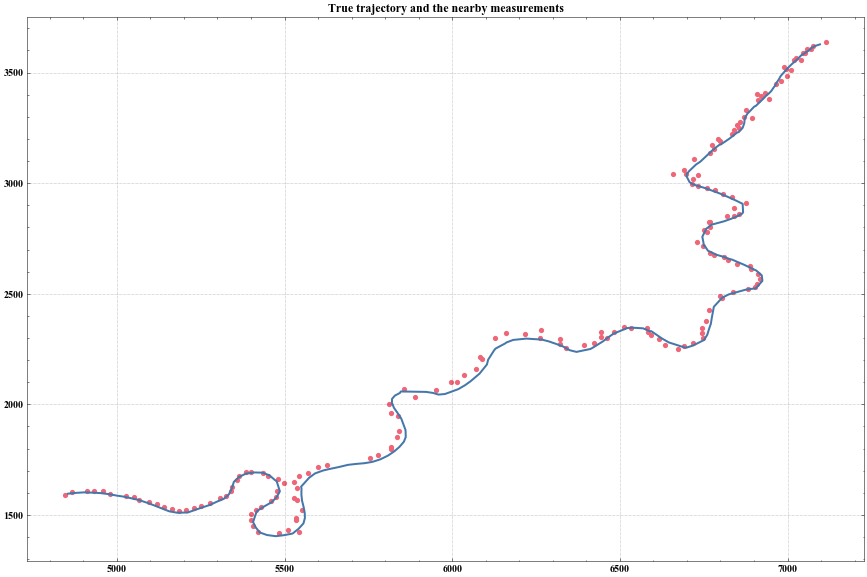

In [47]:
# %% load data and plot
filename_to_load = "data_joyride.mat"
loaded_data = scipy.io.loadmat(filename_to_load)
K     = loaded_data["K"].item()
Ts    = loaded_data["Ts"].squeeze()
Xgt   = loaded_data["Xgt"].T
Z     = [zk.T for zk in loaded_data["Z"].ravel()]
Times = loaded_data["time"]

# plot measurements close to the trajectory
fig1, ax1 = plt.subplots(num=1, clear=True, figsize=(15,10))

Z_plot_data = np.empty((0, 2), dtype=float)
plot_measurement_distance = 100
for Zk, xgtk in zip(Z, Xgt):
    to_plot = np.linalg.norm(Zk - xgtk[None:2], axis=1) <= plot_measurement_distance
    Z_plot_data = np.append(Z_plot_data, Zk[to_plot], axis=0)

ax1.scatter(*Z_plot_data.T, s=5, color="C1", linewidths=3)
ax1.plot(*Xgt.T[:2], color="C0", linewidth=2)
ax1.set_title("True trajectory and the nearby measurements")
plt.show(block=False)

In [48]:
# %% EKF-PDA
## Flags
EKF_CV = False
EKF_CT = not EKF_CV

# sens
sigma_z           = 20
clutter_intensity = 1e-6
PD                = 0.90
gate_size         = 2

# dynamic models
sigma_a_CV        = 2.1
sigma_a_CT        = 2.1
sigma_omega       = 0.005 * np.pi

if EKF_CV:
    mean_init     = Xgt[0]
    cov_init      = np.diag([sigma_z, sigma_z, 10, 10]) ** 2 
    state_dim     = 4
    dynamic_model = dynamicmodels.WhitenoiseAccelleration(sigma_a_CV, n=state_dim)
    
elif EKF_CT: 
    mean_init     = [*Xgt[0], 0]
    cov_init      = np.diag([sigma_z, sigma_z, 10, 10, 0.5]) ** 2
    state_dim     = 5
    dynamic_model = dynamicmodels.ConstantTurnrate(sigma_a_CT, sigma_omega)
    
measurement_model = measurementmodels.CartesianPosition(sigma_z, state_dim=state_dim)

ekf_filter        = ekf.EKF(dynamic_model, measurement_model)
tracker           = pda.PDA(ekf_filter, clutter_intensity, PD, gate_size)
init_state        = GaussParams(mean_init, cov_init)

Ts_mean = np.mean(Ts)
Ts      = [0, *Ts]

NEES    = np.zeros(K)
NEESpos = np.zeros(K)
NEESvel = np.zeros(K)

tracker_update        = init_state
tracker_update_list   = []
tracker_predict_list  = []
tracker_estimate_list = []
# estimate
for k, (Zk, x_true_k) in enumerate(zip(Z, Xgt)):
    
    tracker_predict  = tracker.predict(tracker_update, Ts[k])
    tracker_update   = tracker.update(Zk, tracker_predict)

    tracker_estimate = tracker.estimate(tracker_update)

    NEES[k]    = estats.NEES(*tracker_estimate, x_true_k, idxs=np.arange(4))
    NEESpos[k] = estats.NEES(*tracker_estimate, x_true_k, idxs=np.arange(2))
    NEESvel[k] = estats.NEES(*tracker_estimate, x_true_k, idxs=np.arange(2, 4))

    tracker_predict_list.append(tracker_predict)
    tracker_update_list.append(tracker_update) 
    tracker_estimate_list.append(tracker_estimate)

x_hat = np.array([est.mean for est in tracker_estimate_list])

if EKF_CT:   x_hat_ct = x_hat
elif EKF_CV: x_hat_cv = x_hat

# calculate a performance metrics
poserr = np.linalg.norm(x_hat[:, :2]  - Xgt[:, :2], axis=0)
velerr = np.linalg.norm(x_hat[:, 2:4] - Xgt[:, 2:4], axis=0)
posRMSE = np.sqrt(np.mean(poserr ** 2)) # not true RMSE (which is over monte carlo simulations)
velRMSE = np.sqrt(np.mean(velerr ** 2)) # not true RMSE (which is over monte carlo simulations)
peak_pos_deviation = poserr.max()
peak_vel_deviation = velerr.max()


# consistency
confprob = 0.9
CI2 = np.array(scipy.stats.chi2.interval(confprob, 2))
CI4 = np.array(scipy.stats.chi2.interval(confprob, 4))

CI2K = np.array(scipy.stats.chi2.interval(confprob, 2 * K)) / K
CI4K = np.array(scipy.stats.chi2.interval(confprob, 4 * K)) / K
ANEESpos = np.mean(NEESpos)
ANEESvel = np.mean(NEESvel)
ANEES    = np.mean(NEES)

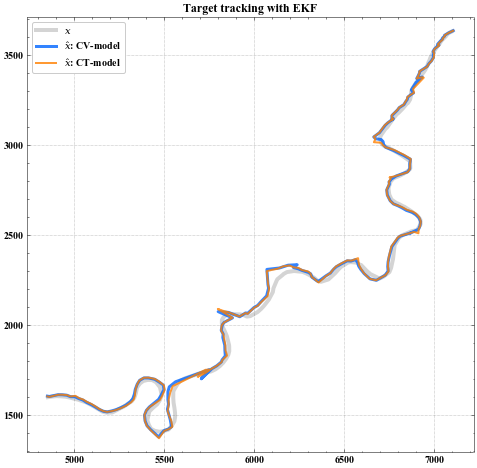

In [49]:
# %% plots
# trajectory
fig3, axs3 = plt.subplots(num=1, clear=True, figsize=(8,8))
axs3.plot(*Xgt.T[:2], label="$x$", color=(0, 0, 0, 0.17), linewidth=4)
axs3.plot(*x_hat_cv.T[:2], label=r"$\hat x$: CV-model", color=(0.0, 0.4, 1, 0.8), linewidth=3)
axs3.plot(*x_hat_ct.T[:2], label=r"$\hat x$: CT-model", color=(1, 0.5, 0.0, 0.8), linewidth=2)
axs3.set_title("Target tracking with EKF")

axs3.axis("equal")
#axs3.set_ylabel("y-position", fontdict={'family':'sans-serif'})
#axs3.set_xlabel("x-position", fontdict={'family':'sans-serif'})
axs3.legend(loc="upper left")
#fig3.savefig("joyride_EKF_1.pdf",format="pdf")


ANEESpos = 2.09 with CI = [1.77, 2.24]
ANEESvel = 0.93 with CI = [1.77, 2.24]
ANEES = 3.73 with CI = [3.68, 4.33]


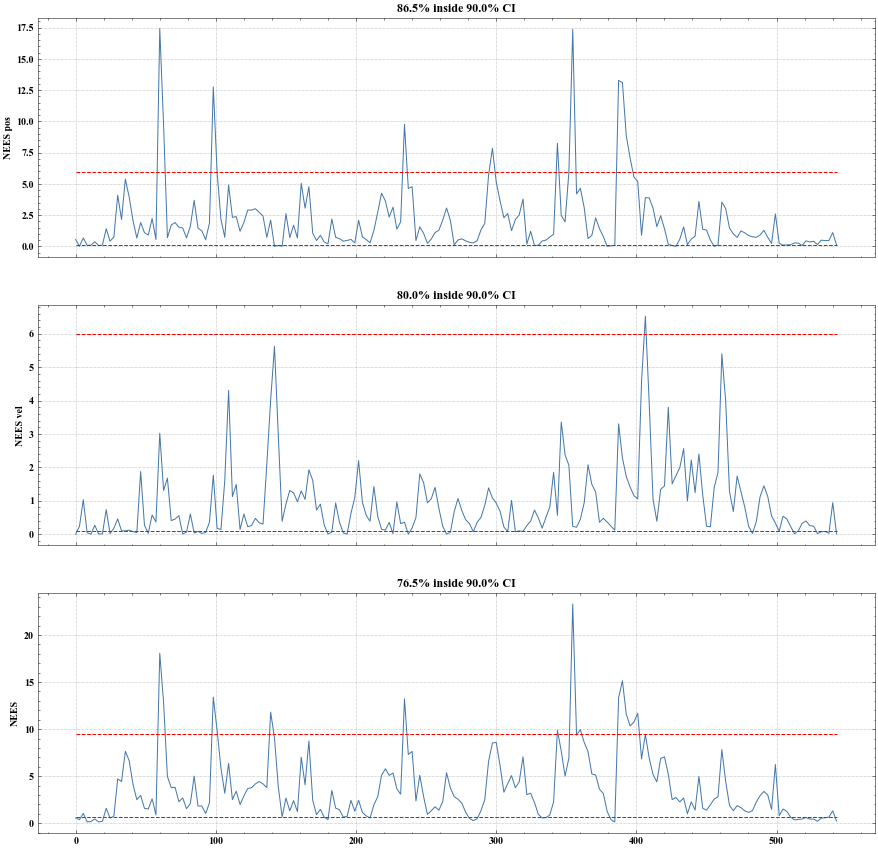

In [50]:
# NEES
fig4, axs4 = plt.subplots(3, sharex=True, num=4, clear=True, figsize=(15,15))
axs4[0].plot(np.arange(K) * Ts_mean, NEESpos)
axs4[0].plot([0, (K - 1) * Ts_mean], np.repeat(CI2[None], 2, 0), "--r")
axs4[0].set_ylabel("NEES pos")
inCIpos = np.mean((CI2[0] <= NEESpos) * (NEESpos <= CI2[1]))
axs4[0].set_title(f"{inCIpos*100:.1f}% inside {confprob*100:.1f}% CI")

axs4[1].plot(np.arange(K) * Ts_mean, NEESvel)
axs4[1].plot([0, (K - 1) * Ts_mean], np.repeat(CI2[None], 2, 0), "--r")
axs4[1].set_ylabel("NEES vel")
inCIvel = np.mean((CI2[0] <= NEESvel) * (NEESvel <= CI2[1]))
axs4[1].set_title(f"{inCIvel*100:.1f}% inside {confprob*100:.1f}% CI")

axs4[2].plot(np.arange(K) * Ts_mean, NEES)
axs4[2].plot([0, (K - 1) * Ts_mean], np.repeat(CI4[None], 2, 0), "--r")
axs4[2].set_ylabel("NEES")
inCI = np.mean((CI4[0] <= NEES) * (NEES <= CI4[1]))
axs4[2].set_title(f"{inCI*100:.1f}% inside {confprob*100:.1f}% CI")

print(f"ANEESpos = {ANEESpos:.2f} with CI = [{CI2K[0]:.2f}, {CI2K[1]:.2f}]")
print(f"ANEESvel = {ANEESvel:.2f} with CI = [{CI2K[0]:.2f}, {CI2K[1]:.2f}]")
print(f"ANEES = {ANEES:.2f} with CI = [{CI4K[0]:.2f}, {CI4K[1]:.2f}]")

RMSE(pos, vel) = (339.986, 50.942)
peak_dev(pos, vel) = (374.730, 57.500)


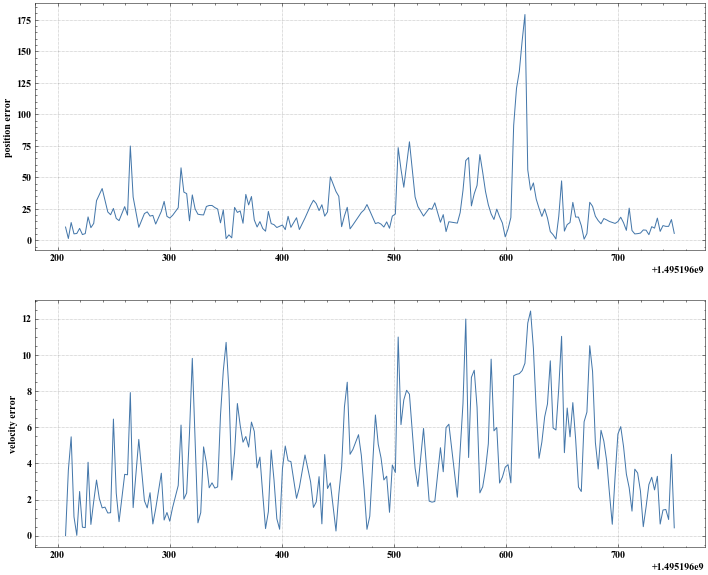

In [46]:
# errors
fig5, axs5 = plt.subplots(2, num=5, clear=True, figsize=(12,10))
axs5[0].plot(Times, np.linalg.norm(x_hat[:, :2] - Xgt[:, :2], axis=1))
axs5[0].set_ylabel("position error")

axs5[1].plot(Times, np.linalg.norm(x_hat[:, 2:4] - Xgt[:, 2:4], axis=1))
axs5[1].set_ylabel("velocity error")

print( f"RMSE(pos, vel) = ({posRMSE:.3f}, {velRMSE:.3f})\npeak_dev(pos, vel) = ({peak_pos_deviation:.3f}, {peak_vel_deviation:.3f})")